<a href="https://colab.research.google.com/github/rosipapa/colab/blob/main/detect_fake_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


DATASET

\\


The Fake-or-Real Dataset : https://bil.eecs.yorku.ca/datasets/

version: for-2sec with the files truncated at 2 seconds

\\


**Training** dataset - two directorios: real and fake


\\

dataset/

├── real/

│   ├── real_audio_1.wav

│   ├── real_audio_2.wav

│   └── ...

└── fake/

│   ├── fake_audio_1.wav

│   ├── fake_audio_2.wav

│   └── ...


\\

**Test** dataset - all files (real and fake) in the same directory. For prediction was used a sample of the dataset test, around 400 files.

\\

In [ ]:
# Load google driver
from google.colab import drive
# Mount Google Drive
# Ask permission to Gmail user
drive.mount('/drive')

Mounted at /drive


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install librosa tensorflow


In [ ]:
# Import libraries
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [ ]:
# Set the paths to dataset
data_path ='drive/My Drive/Colab Notebooks/datasets/for-2sec-training'

test_data_path = 'drive/My Drive/Colab Notebooks/datasets/for-2sec-testing'

runtime below: 7 minutes

In [ ]:
# Function to load and preprocess audio data
def load_and_preprocess_data(data_dir, label):
    data = []
    labels = []

    for filename in os.listdir(data_dir):
        if filename.endswith('.wav'):
            file_path = os.path.join(data_dir, filename)
            audio_data, _ = librosa.load(file_path, sr=16000)
            data.append(audio_data)
            labels.append(label)

    return data, labels

# Load and preprocess the dataset
real_data, real_labels = load_and_preprocess_data(os.path.join(data_path, 'real'), label =0)
fake_data, fake_labels = load_and_preprocess_data(os.path.join(data_path, 'fake'), label=1)

# Combine real and fake data
data = np.array(real_data + fake_data)
labels = np.array(real_labels + fake_labels)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

# Function to preprocess audio data to spectrograms
def preprocess_audio(audio_data):
    # Compute the Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=16000)
    # Convert to decibels (log scale)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return log_mel_spectrogram

X_train = np.array([preprocess_audio(audio) for audio in X_train])
X_val = np.array([preprocess_audio(audio) for audio in X_val])

In [ ]:
# Function to count instances of the "real" class
def count_real_instances(labels):
    return sum(label == 0 for label in labels)

# Count "real" instances in X_train and X_val
real_instances_train = count_real_instances(y_train)
real_instances_val = count_real_instances(y_val)

print(f"Number of 'real' instances in X_train: {real_instances_train}")
print(f"Number of 'real' instances in X_val: {real_instances_val}")


def count_fake_instances(labels):
    return sum(label == 1 for label in labels)

# Count "real" instances in X_train and X_val
fake_instances_train = count_fake_instances(y_train)
fake_instances_val = count_fake_instances(y_val)

print(f"Number of 'fake' instances in X_train: {fake_instances_train}")
print(f"Number of 'fake' instances in X_val: {fake_instances_val}")

Number of 'real' instances in X_train: 5569
Number of 'real' instances in X_val: 1409
Number of 'fake' instances in X_train: 5595
Number of 'fake' instances in X_val: 1383


runtime below: 1,5 minutes

In [ ]:
X_train

array([[[-50.363205 , -55.638718 , -77.345314 , ..., -80.       ,
         -59.126884 , -43.047703 ],
        [-48.836563 , -54.46798  , -70.89202  , ..., -80.       ,
         -57.321804 , -42.217384 ],
        [-46.413048 , -51.88707  , -68.77721  , ..., -77.41264  ,
         -57.04541  , -41.692326 ],
        ...,
        [-69.120636 , -62.19056  , -49.864853 , ..., -80.       ,
         -74.128204 , -62.08258  ],
        [-69.18856  , -63.03822  , -49.972305 , ..., -80.       ,
         -77.93053  , -66.70357  ],
        [-70.266846 , -72.60335  , -65.52823  , ..., -80.       ,
         -80.       , -67.87488  ]],

       [[-52.77617  , -55.958946 , -59.610886 , ..., -62.35364  ,
         -64.07813  , -50.026688 ],
        [-45.734    , -50.130722 , -60.961983 , ..., -60.155357 ,
         -60.174995 , -46.71342  ],
        [-41.8347   , -47.8106   , -56.79603  , ..., -57.76944  ,
         -57.772255 , -42.92365  ],
        ...,
        [-72.81301  , -78.65063  , -80.       , ..., -

In [ ]:
# Define the deep learning model
model = models.Sequential([
    layers.Input(shape=X_train[0].shape),
    layers.Conv1D(16, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
#model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)




Epoch 1/10
349/349 [==============================] - 4s 7ms/step - loss: 1.2211 - accuracy: 0.5956 - val_loss: 0.6329 - val_accuracy: 0.6483
Epoch 2/10
349/349 [==============================] - 2s 6ms/step - loss: 0.5895 - accuracy: 0.6862 - val_loss: 0.5755 - val_accuracy: 0.6931
Epoch 3/10
349/349 [==============================] - 2s 7ms/step - loss: 0.5513 - accuracy: 0.7133 - val_loss: 0.5675 - val_accuracy: 0.7038
Epoch 4/10
349/349 [==============================] - 3s 9ms/step - loss: 0.4909 - accuracy: 0.7512 - val_loss: 0.4933 - val_accuracy: 0.7607
Epoch 5/10
349/349 [==============================] - 3s 8ms/step - loss: 0.4502 - accuracy: 0.7802 - val_loss: 0.4558 - val_accuracy: 0.7958
Epoch 6/10
349/349 [==============================] - 2s 5ms/step - loss: 0.3518 - accuracy: 0.8410 - val_loss: 0.3133 - val_accuracy: 0.8671
Epoch 7/10
349/349 [==============================] - 2s 6ms/step - loss: 0.2733 - accuracy: 0.8810 - val_loss: 0.3308 - val_accuracy: 0.8489
Epoch 

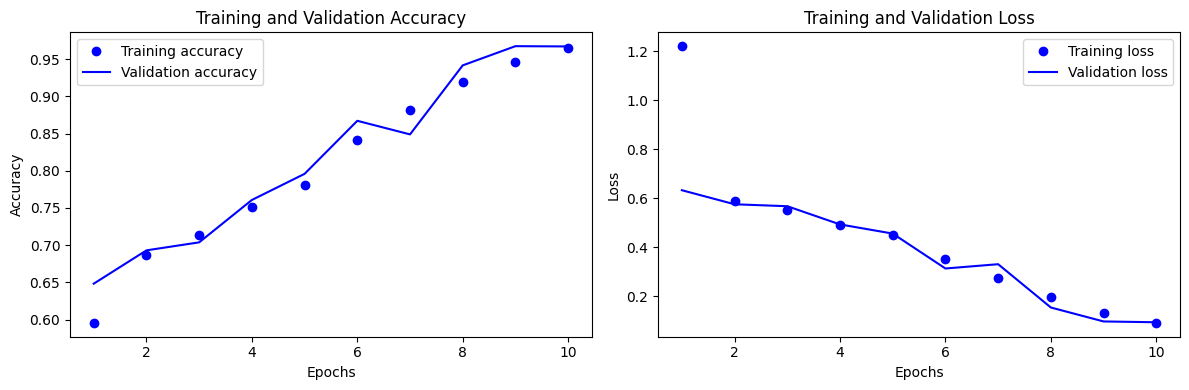

Best Validation Accuracy: 0.9674 (Epoch 9)


In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Get training and validation accuracy values
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Get training and validation loss values
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Number of epochs
    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print best validation accuracy
    best_val_accuracy_epoch = val_acc.index(max(val_acc)) + 1
    best_val_accuracy = max(val_acc)
    print(f'Best Validation Accuracy: {best_val_accuracy:.4f} (Epoch {best_val_accuracy_epoch})')



# Plot the training history
plot_training_history(history)


In [ ]:
#import os
#import pandas as pd
#import librosa
#import numpy as np


# Predict authenticity on the test dataset (dataset with files to be predicted)
def predict_authenticity(model, data_path):
    data = []

    for label, sub_dir in enumerate(['real', 'fake']):
        sub_path = os.path.join(data_path, sub_dir)
        for audio_file in os.listdir(sub_path):
            if audio_file.endswith('.wav'):
                file_path = os.path.join(sub_path, audio_file)
                audio_data, _ = librosa.load(file_path, sr=16000)
                audio_data = preprocess_audio(audio_data)
                audio_data = np.expand_dims(audio_data, axis=0)

                prediction = model.predict(audio_data)
                predicted_label = 1 if prediction > 0.5 else 0

                data.append([audio_file, label, predicted_label])

    df = pd.DataFrame(data, columns=['Audio Filename', 'True Label', 'Predicted Label'])
    return df

# Assume 'test_data_path' is the path to the directory containing 'real' and 'fake' subdirectories.
test_results = predict_authenticity(model, test_data_path)

# Calculate accuracy on the test dataset
accuracy = (test_results['True Label'] == test_results['Predicted Label']).mean()
print(f"Accuracy on the test dataset: {accuracy:.4f}")

# Display the results in a DataFrame
print(test_results)


1/1 [==============================] - 0s 26ms/step
Accuracy on the test dataset: 0.7886
                                         Audio Filename  True Label  \
0     file121.wav_16k.wav_norm.wav_mono.wav_silence....           0   
1     file1097.wav_16k.wav_norm.wav_mono.wav_silence...           0   
2     file1257.wav_16k.wav_norm.wav_mono.wav_silence...           0   
3     file1089.wav_16k.wav_norm.wav_mono.wav_silence...           0   
4     file1044.wav_16k.wav_norm.wav_mono.wav_silence...           0   
...                                                 ...         ...   
1083  file487.wav_16k.wav_norm.wav_mono.wav_silence....           1   
1084  file490.wav_16k.wav_norm.wav_mono.wav_silence....           1   
1085  file761.wav_16k.wav_norm.wav_mono.wav_silence....           1   
1086  file881.wav_16k.wav_norm.wav_mono.wav_silence....           1   
1087  file574.wav_16k.wav_norm.wav_mono.wav_silence....           1   

      Predicted Label  
0                   0  
1         

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 126, 16)           3040      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 63, 16)            0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 61, 32)            1568      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 30, 32)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 960)               0         
                                                                 
 dense_2 (Dense)             (None, 64)               

88/88 [==============================] - 0s 3ms/step


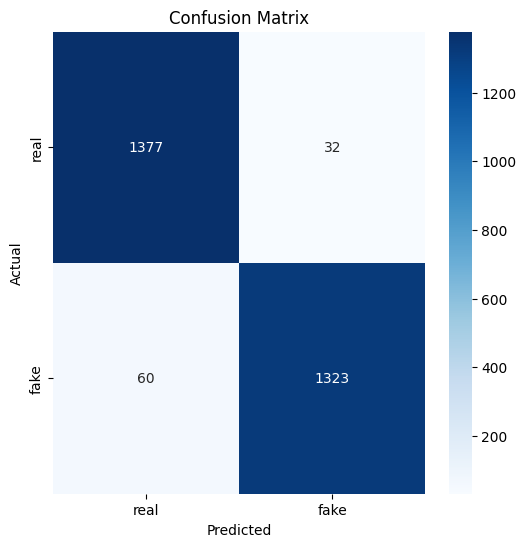

In [ ]:
#CONFUSION MATRIX FOR VALIDATION DATA USED TO TRAIN THE MODEL

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, X, y, labels, title='Confusion Matrix'):
    # Get model predictions
    y_pred = model.predict(X)
    y_pred = np.round(y_pred)  # Convert probabilities to binary labels

    # Generate a confusion matrix
    cm = confusion_matrix(y, y_pred)

    # Create a figure and a set of subplots
    plt.figure(figsize=(6, 6))

    # Plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)

    # Show the plot
    plt.show()

plot_confusion_matrix(model, X_val, y_val, labels=['real', 'fake'])


[-0.10726639 -0.11896672 -0.10226737 ... -0.12161377 -0.1365962
 -0.08514544] 22050


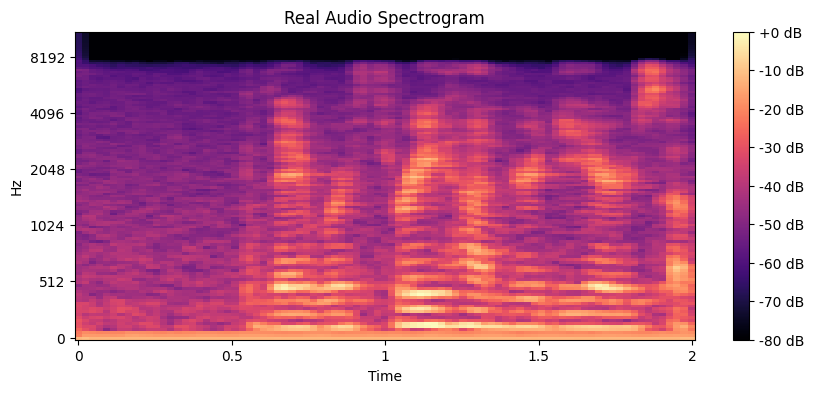

[ 0.31815138  0.26314637  0.00566594 ... -0.15579155  0.0235047
  0.10799523] 22050


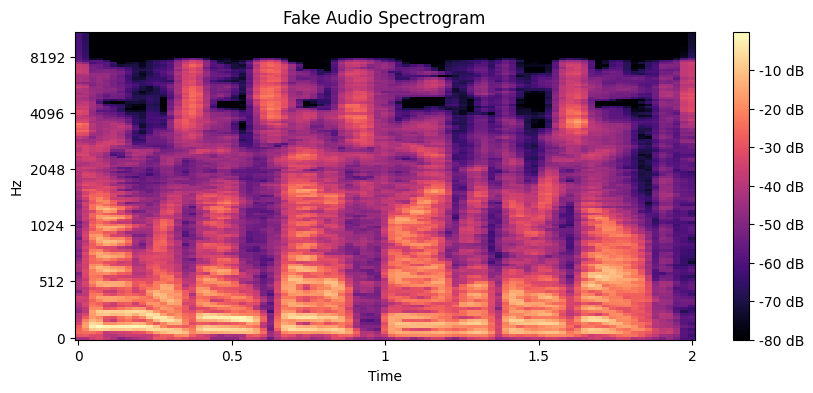

In [ ]:
import librosa.display
import matplotlib.pyplot as plt

def plot_audio_spectrogram(audio_path, title):
    # Load the audio file
    audio_data, sample_rate = librosa.load(audio_path)
    print(audio_data, sample_rate)

    # Compute the spectrogram
    spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    # Display the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_spectrogram, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()


plot_audio_spectrogram('drive/My Drive/Colab Notebooks/datasets/dataset_audio_sample/real_test/file88_real.wav', 'Real Audio Spectrogram')
plot_audio_spectrogram('drive/My Drive/Colab Notebooks/datasets/dataset_audio_sample/fake_test/file242_fake.wav', 'Fake Audio Spectrogram')


In [ ]:
# PREDICT IF A SINGLE AUDIO IS REAL OR FAKE

import librosa
import numpy as np

# Function to preprocess audio data to spectrograms
def preprocess_audio(audio_data):
    # Compute the Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=16000)
    # Convert to decibels (log scale)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return log_mel_spectrogram

# Function to predict if a single audio file is real or fake
def predict_single_audio(model, audio_path):
    # Load the audio file
    audio_data, _ = librosa.load(audio_path, sr=16000)

    # Preprocess the audio data
    preprocessed_audio = preprocess_audio(audio_data)
    preprocessed_audio = np.expand_dims(preprocessed_audio, axis=0)

    # Make the prediction using the model
    prediction = model.predict(preprocessed_audio)

    # Determine the label based on the prediction
    label = 'fake' if prediction > 0.5 else 'real'

    return label


result = predict_single_audio(model, 'drive/My Drive/Colab Notebooks/datasets/dataset_audio_sample/fake_test/file48_fake.wav')
print(f"The FAKE audio is predicted to be {result}.")

result = predict_single_audio(model, 'drive/My Drive/Colab Notebooks/datasets/dataset_audio_sample/real_test/file88_real.wav')
print(f"The REAL audio is predicted to be {result}.")


1/1 [==============================] - 0s 34ms/step
The FAKE audio is predicted to be fake.
1/1 [==============================] - 0s 33ms/step
The REAL audio is predicted to be real.


# Play audio

In [ ]:
pip install pydub

In [ ]:
from IPython.display import Audio, display
import time
from pydub import AudioSegment
from pydub.playback import play

time.sleep(3)

def play_audio_files(real_audio_file, fake_audio_file):
    # Load audio files
    real_audio = AudioSegment.from_wav(real_audio_file)
    fake_audio = AudioSegment.from_wav(fake_audio_file)

    # Play real audio
    print("Playing Real Audio...")
    #play(real_audio)
    display(Audio(real_audio_file, autoplay=True))

    time.sleep(5)
    # Play fake audio
    print("Playing Fake Audio...")
    # play(fake_audio)
    display(Audio(fake_audio_file, autoplay=True))

fake_audio_file = 'drive/My Drive/Colab Notebooks/datasets/dataset_audio_sample/fake_test/file48_fake.wav'
real_audio_file = 'drive/My Drive/Colab Notebooks/datasets/dataset_audio_sample/real_test/file88_real.wav'

play_audio_files(real_audio_file, fake_audio_file)


Playing Real Audio...


Playing Fake Audio...


# Audio representation as Waveform, MFCC and Spectogram

<ipython-input-28-bcd9d5328dec>:16: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  fake_spec = librosa.amplitude_to_db(librosa.stft(fake_audio), ref=np.max)
<ipython-input-28-bcd9d5328dec>:17: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  real_spec = librosa.amplitude_to_db(librosa.stft(real_audio), ref=np.max)


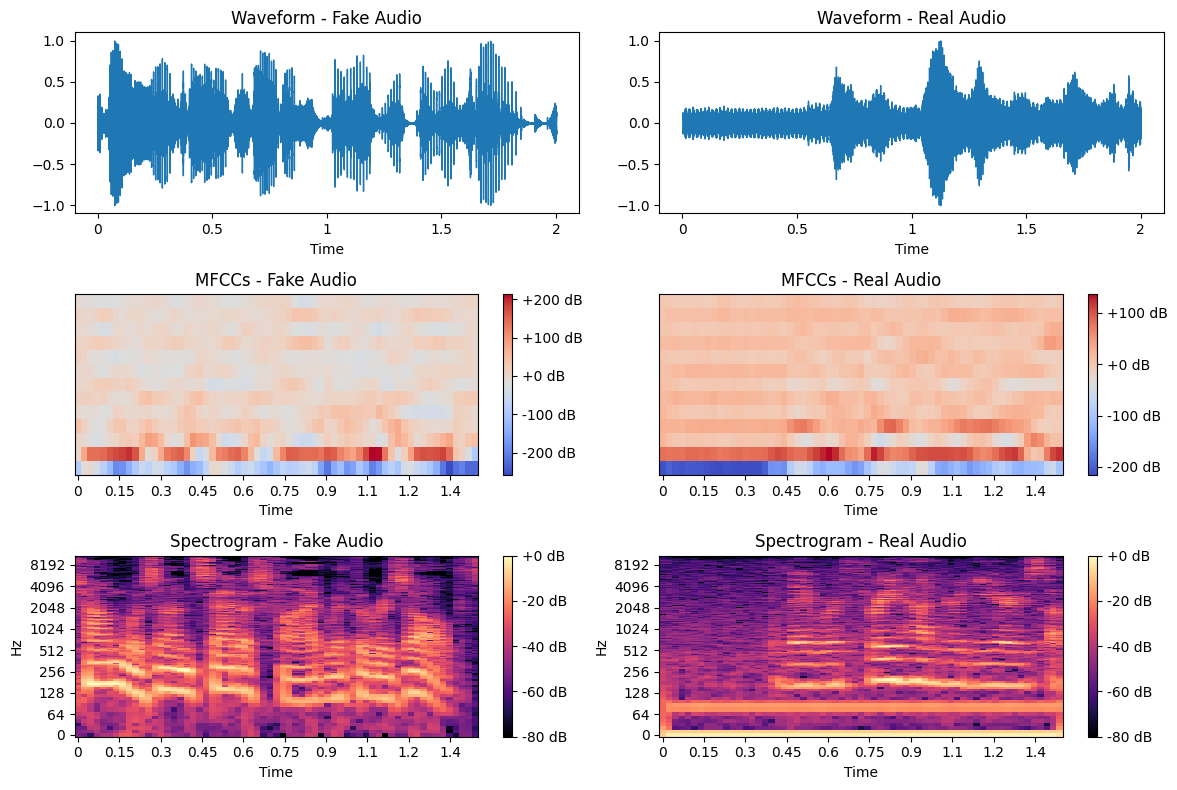

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def plot_waveform_mfcc_spectrogram(fake_audio_file, real_audio_file, save_plots=False):
    # Load audio files
    fake_audio, sr_fake = librosa.load(fake_audio_file, sr=None)
    real_audio, sr_real = librosa.load(real_audio_file, sr=None)

    # Compute MFCCs
    fake_mfccs = librosa.feature.mfcc(y=fake_audio, sr=sr_fake, n_mfcc=13)
    real_mfccs = librosa.feature.mfcc(y=real_audio, sr=sr_real, n_mfcc=13)

    # Compute Spectrograms
    fake_spec = librosa.amplitude_to_db(librosa.stft(fake_audio), ref=np.max)
    real_spec = librosa.amplitude_to_db(librosa.stft(real_audio), ref=np.max)

    # Plot Waveform
    plt.figure(figsize=(12, 8))
    plt.subplot(3, 2, 1)
    librosa.display.waveshow(fake_audio, sr=sr_fake)
    plt.title('Waveform - Fake Audio')

    plt.subplot(3, 2, 2)
    librosa.display.waveshow(real_audio, sr=sr_real)
    plt.title('Waveform - Real Audio')

    # Plot MFCCs
    plt.subplot(3, 2, 3)
    librosa.display.specshow(fake_mfccs, x_axis='time')
    plt.title('MFCCs - Fake Audio')
    plt.colorbar(format='%+2.0f dB')

    plt.subplot(3, 2, 4)
    librosa.display.specshow(real_mfccs, x_axis='time')
    plt.title('MFCCs - Real Audio')
    plt.colorbar(format='%+2.0f dB')

    # Plot Spectrograms
    plt.subplot(3, 2, 5)
    librosa.display.specshow(fake_spec, x_axis='time', y_axis='log')
    plt.title('Spectrogram - Fake Audio')
    plt.colorbar(format='%+2.0f dB')

    plt.subplot(3, 2, 6)
    librosa.display.specshow(real_spec, x_axis='time', y_axis='log')
    plt.title('Spectrogram - Real Audio')
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()

    if save_plots:
        plt.savefig('audio_plots.png')
    else:
        plt.show()


fake_audio_file = 'drive/My Drive/Colab Notebooks/datasets/dataset_audio_sample/fake_test/file242_fake.wav'
real_audio_file = 'drive/My Drive/Colab Notebooks/datasets/dataset_audio_sample/real_test/file88_real.wav'
plot_waveform_mfcc_spectrogram(fake_audio_file, real_audio_file, save_plots=False)

